# Proyek Klasifikasi Gambar: [Food11]
- **Nama:** Surya Yusuf Nugroho
- **Email:** suryanugroho042@gmail.com
- **ID Dicoding:** suryayyyyy

## Import Semua Packages/Library yang Digunakan

In [2]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D
from google.colab import drive
from google.colab import files
import PIL
import albumentations as A
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import load_model
import tensorflow.lite as tflite

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"synjoestar","key":"9e0b44f130883e1960ac2b12e3874ef8"}'}

In [4]:
# Hapus dataset lama jika ada
!rm -rf rice_image_dataset/ rice-image-dataset.zip

In [5]:
# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d muratkokludataset/rice-image-dataset

# Unzip dataset ke dalam folder rice_image_dataset
!unzip -q rice-image-dataset.zip -d rice_image_dataset

# Hapus file zip untuk menghemat penyimpanan
!rm rice-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 99% 217M/219M [00:01<00:00, 170MB/s]
100% 219M/219M [00:01<00:00, 143MB/s]


In [6]:
!ls rice_image_dataset

Rice_Image_Dataset


In [7]:
dataset_path = "/content/rice_image_dataset/Rice_Image_Dataset"
classes = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]

print(f"Jumlah kelas yang valid: {len(classes)}")
print(f"Kelas yang tersedia: {classes}")

Jumlah kelas yang valid: 5
Kelas yang tersedia: ['Basmati', 'Ipsala', 'Arborio', 'Jasmine', 'Karacadag']


In [8]:
# Cek Jumlah gambar /kelas
for c in classes:
    num_images = len(os.listdir(os.path.join(dataset_path, c)))
    print(f"Kelas {c}: {num_images} gambar")

Kelas Basmati: 15000 gambar
Kelas Ipsala: 15000 gambar
Kelas Arborio: 15000 gambar
Kelas Jasmine: 15000 gambar
Kelas Karacadag: 15000 gambar


In [9]:
# Cek apakah semua gambar valid
for c in classes:
    class_path = os.path.join(dataset_path, c)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()  # Cek validitas gambar
        except Exception as e:
            print(f"Masalah dengan {img_path}: {e}")

### Data Preprocessing

#### Split Dataset

In [10]:
# Path dataset asli
dataset_path = "/content/rice_image_dataset/Rice_Image_Dataset"
train_path = "/content/train"
val_path = "/content/val"
test_path = "/content/test"

# Buat folder train, val, test
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Split dataset
for category in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, category)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        # Split 85% train+valid dan 15% test
        train_valid_images, test_images = train_test_split(images, test_size=0.15, random_state=42)

        # Split 70% train dan 15% valid dari train+valid
        train_images, val_images = train_test_split(train_valid_images, test_size=0.1765, random_state=42)  # 15/85 ≈ 0.1765

        # Pindahkan ke folder train, val, test
        os.makedirs(os.path.join(train_path, category), exist_ok=True)
        os.makedirs(os.path.join(val_path, category), exist_ok=True)
        os.makedirs(os.path.join(test_path, category), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_path, category, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_path, category, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_path, category, img))

print("Dataset berhasil dipisah!")


Dataset berhasil dipisah!


In [11]:
# Data Augmentation untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Hanya rescale untuk validasi dan test
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset dengan ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Untuk evaluasi, jangan di-shuffle
)

print(f"Total Train Images: {train_generator.samples}")
print(f"Total Validation Images: {valid_generator.samples}")
print(f"Total Test Images: {test_generator.samples}")


Found 52495 images belonging to 5 classes.
Found 11255 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Total Train Images: 52495
Total Validation Images: 11255
Total Test Images: 11250


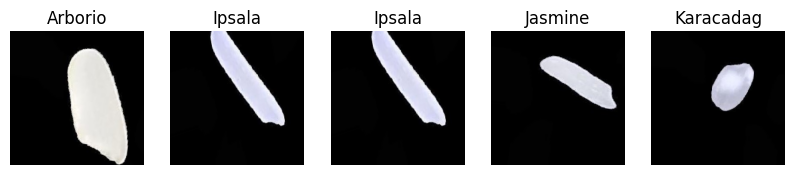

In [13]:
# Ambil beberapa sampel dari train generator
batch = next(train_generator)  # train_generator adalah ImageDataGenerator dari dataset training
images, labels = batch  # Pisahkan gambar dan labelnya

# Menampilkan 5 gambar acak
plt.figure(figsize=(10, 5))
for i in range(5):
    idx = random.randint(0, len(images) - 1)
    img = array_to_img(images[idx])  # Konversi dari array ke gambar
    label = classes[np.argmax(labels[idx])]  # Ambil nama kelasnya

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.show()

## Modelling

In [37]:
# Callback untuk menghentikan training jika val_loss tidak membaik setelah 5 epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Callback untuk menurunkan learning rate jika val_loss stagnan selama 3 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, min_lr=1e-6)

# Callback untuk menyimpan model terbaik dalam format .h5
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Gabungkan semua callback
callbacks = [early_stopping, reduce_lr, model_checkpoint]


In [15]:
# Hyperparameters
IMG_SIZE = (224, 224, 3)
NUM_CLASSES = 5  # Ganti sesuai jumlah kelas pada dataset

# Load Pre-trained ResNet50
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
base_resnet.trainable = False  # Freeze pre-trained layers

# Load Pre-trained MobileNetV2
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
base_mobilenet.trainable = False  # Freeze pre-trained layers

# Function to create model
def build_model(base_model, name="Model"):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create models
resnet_model = build_model(base_resnet, "ResNet50_Model")
mobilenet_model = build_model(base_mobilenet, "MobileNetV2_Model")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_resnet.layers[-10:]:  # Unfreeze 10 layer terakhir
    layer.trainable = True

for layer in base_mobilenet.layers[-10:]:
    layer.trainable = True

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet_finetune = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Bisa disesuaikan
    callbacks=callbacks
)

history_mobilenet_finetune = mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Bisa disesuaikan
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6072 - loss: 0.9228
Epoch 1: val_loss improved from inf to 0.30959, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 696s 412ms/step - accuracy: 0.6073 - loss: 0.9226 - val_accuracy: 0.8707 - val_loss: 0.3096 - learning_rate: 1.0000e-05
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8340 - loss: 0.4061
Epoch 2: val_loss improved from 0.30959 to 0.21903, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 711s 400ms/step - accuracy: 0.8340 - loss: 0.4061 - val_accuracy: 0.9282 - val_loss: 0.2190 - learning_rate: 1.0000e-05
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8564 - loss: 0.3511
Epoch 3: val_loss improved from 0.21903 to 0.21497, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 671s 393ms/step - accuracy: 0.8564 - loss: 0.3511 - val_accuracy: 0.9225 - val_loss: 0.2150 - learning_rate: 1.0000e-05
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8745 - loss: 0.3117
Epoch 4: val_loss improved from 0.21497 to 0.17072, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 688s 396ms/step - accuracy: 0.8745 - loss: 0.3117 - val_accuracy: 0.9445 - val_loss: 0.1707 - learning_rate: 1.0000e-05
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8815 - loss: 0.2904
Epoch 5: val_loss did not improve from 0.17072
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 658s 401ms/step - accuracy: 0.8815 - loss: 0.2904 - val_accuracy: 0.9362 - val_loss: 0.1820 - learning_rate: 1.0000e-05
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8907 - loss: 0.2759
Epoch 6: val_loss improved from 0.17072 to 0.16881, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 650s 396ms/step - accuracy: 0.8907 - loss: 0.2759 - val_accuracy: 0.9384 - val_loss: 0.1688 - learning_rate: 1.0000e-05
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8951 - loss: 0.2626
Epoch 7: val_loss did not improve from 0.16881
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 669s 407ms/step - accuracy: 0.8951 - loss: 0.2626 - val_accuracy: 0.9426 - val_loss: 0.1732 - learning_rate: 1.0000e-05
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9027 - loss: 0.2461
Epoch 8: val_loss did not improve from 0.16881
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 646s 394ms/step - accuracy: 0.9027 - loss: 0.2461 - val_accuracy: 0.9328 - val_loss: 0.1865 - learning_rate: 1.0000e-05
Epoch 9/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9044 - loss: 0.2398
Epoch 9: val_loss improved from 0.16881 to 0.16385, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 686s 396ms/step - accuracy: 0.9044 - loss: 0.2398 - val_accuracy: 0.9397 - val_loss: 0.1639 - learning_rate: 1.0000e-05
Epoch 10/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9069 - loss: 0.2398
Epoch 10: val_loss did not improve from 0.16385
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 649s 396ms/step - accuracy: 0.9069 - loss: 0.2398 - val_accuracy: 0.9341 - val_loss: 0.1857 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 9.
Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7806 - loss: 0.6065
Epoch 1: val_loss improved from 0.16385 to 0.09524, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 632s 377ms/step - accuracy: 0.7807 - loss: 0.6063 - val_accuracy: 0.9670 - val_loss: 0.0952 - learning_rate: 1.0000e-05
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9534 - loss: 0.1363
Epoch 2: val_loss improved from 0.09524 to 0.07794, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 669s 374ms/step - accuracy: 0.9534 - loss: 0.1363 - val_accuracy: 0.9730 - val_loss: 0.0779 - learning_rate: 1.0000e-05
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9626 - loss: 0.1097
Epoch 3: val_loss improved from 0.07794 to 0.07291, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 610s 371ms/step - accuracy: 0.9626 - loss: 0.1097 - val_accuracy: 0.9755 - val_loss: 0.0729 - learning_rate: 1.0000e-05
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9687 - loss: 0.0883
Epoch 4: val_loss did not improve from 0.07291
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 597s 364ms/step - accuracy: 0.9687 - loss: 0.0883 - val_accuracy: 0.9634 - val_loss: 0.1042 - learning_rate: 1.0000e-05
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9719 - loss: 0.0798
Epoch 5: val_loss did not improve from 0.07291
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 611s 372ms/step - accuracy: 0.9719 - loss: 0.0798 - val_accuracy: 0.9716 - val_loss: 0.0831 - learning_rate: 1.0000e-05
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9736 - loss: 0.0757
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.

Epoch 6: val_loss did not improve from 0.07291
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 598s 364ms/step - accuracy: 

In [22]:
# Load pretrained MobileNetV2 tanpa Fully Connected Layer
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobilenet.trainable = False  # Freeze pretrained layers

# Bangun Model Sequential sesuai kriteria
model = Sequential([
    base_mobilenet,
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Tambahkan Conv2D
    MaxPooling2D(pool_size=(2, 2)),  # Tambahkan Pooling Layer
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output untuk 5 kelas beras
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 64)            │         737,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,004,293 (11.46 MB)

 Trainable params: 746,309 (2.85 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Evaluasi dan Visualisasi

In [31]:
# Load model
model = load_model("best_model.h5")

# Recompile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Retrain model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=2,  # Retrain 1-2 epoch
    callbacks=callbacks
)

Epoch 1/2
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9633 - loss: 0.1038
Epoch 1: val_loss improved from inf to 0.07683, saving model to best_model.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 3804s 2s/step - accuracy: 0.9633 - loss: 0.1038 - val_accuracy: 0.9749 - val_loss: 0.0768 - learning_rate: 1.0000e-04
Epoch 2/2
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9753 - loss: 0.0745
Epoch 2: val_loss did not improve from 0.07683
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 3728s 2s/step - accuracy: 0.9753 - loss: 0.0745 - val_accuracy: 0.9730 - val_loss: 0.0800 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


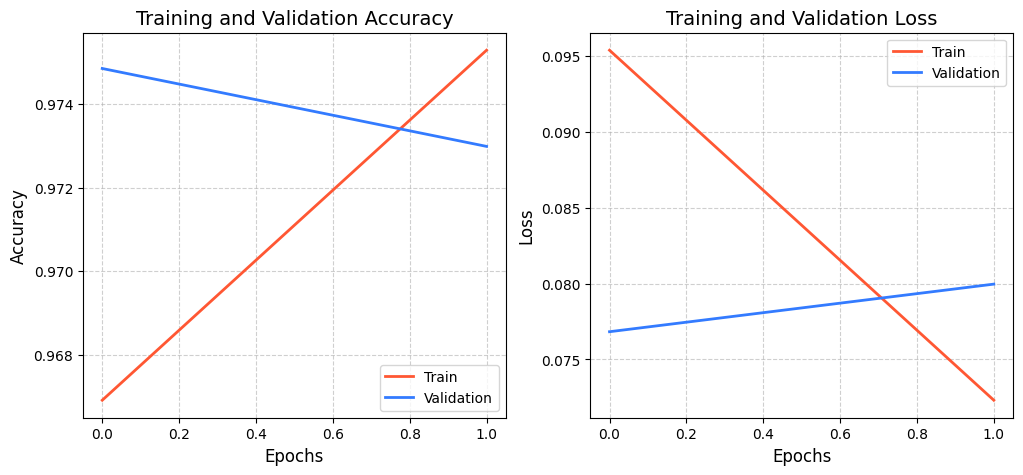

In [33]:
# Data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color="#FF5733", linestyle="-", linewidth=2)
plt.plot(epochs, val_acc, color="#337BFF", linestyle="-", linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True, linestyle="--", alpha=0.6)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color="#FF5733", linestyle="-", linewidth=2)
plt.plot(epochs, val_loss, color="#337BFF", linestyle="-", linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

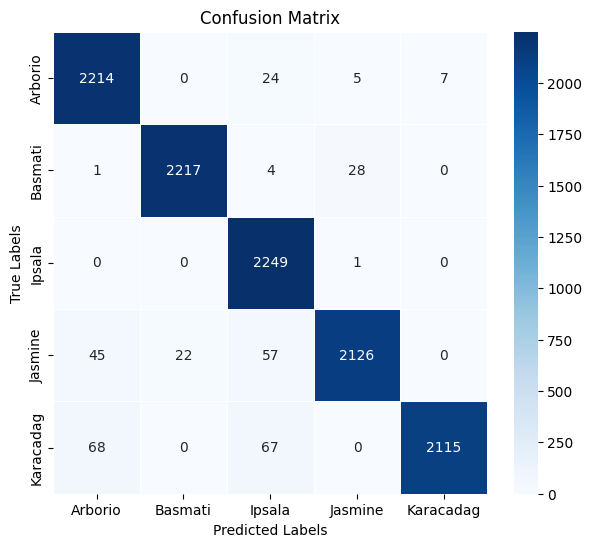


Classification Report:

              precision    recall  f1-score   support

     Arborio     0.9510    0.9840    0.9672      2250
     Basmati     0.9902    0.9853    0.9877      2250
      Ipsala     0.9367    0.9996    0.9671      2250
     Jasmine     0.9843    0.9449    0.9642      2250
   Karacadag     0.9967    0.9400    0.9675      2250

    accuracy                         0.9708     11250
   macro avg     0.9718    0.9708    0.9708     11250
weighted avg     0.9718    0.9708    0.9708     11250



In [36]:
# Reset test generator
test_generator.reset()

# Prediksi model
preds = model.predict(test_generator, verbose=0)

# Konversi hasil prediksi ke label kelas (multi-class)
preds_classes = np.argmax(preds, axis=1)  # Kalau pakai categorical_crossentropy
true_classes = test_generator.classes

# Definisi label kelas sesuai Rice Image Dataset
labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Buat Confusion Matrix
cm = confusion_matrix(true_classes, preds_classes)

plt.figure(figsize=(7,6))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, preds_classes, target_names=labels, digits=4))


## Konversi Model

In [47]:
model.export("saved_model_rice")

Saved artifact at 'saved_model_rice'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138136766586064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766591632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766594512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766587216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766588176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766593936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766588944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766592592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766594896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138136766589328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1381380867118

In [50]:
# Buat direktori jika belum ada
import os
os.makedirs("tflite", exist_ok=True)

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_rice")
tflite_model = converter.convert()

# Simpan hasil model TFLite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label (opsional, jika diperlukan)
labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))


In [54]:
!pip install tensorflowjs

# Buat folder output TFJS jika belum ada
import os
os.makedirs("tfjs_model", exist_ok=True)

# Konversi model ke format TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve saved_model_rice tfjs_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
2025-03-03 04:33:46.821504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740976426.855421   61623 cuda_dnn.cc:8310] Unable to regis

## Inference (Optional)

In [58]:
# Load TFLite model
interpreter = tflite.Interpreter(model_path="/content/tflite/model.tflite")
interpreter.allocate_tensors()

# Dapatkan informasi input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess gambar input (resize ke ukuran model)
def preprocess_image(image_path, input_size):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((input_size, input_size))
    img = np.array(img, dtype=np.float32) / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambah batch dimensi
    return img

# Load gambar uji
image_path = "/content/Arborio (10012).jpg"
input_size = input_details[0]['shape'][1]
input_data = preprocess_image(image_path, input_size)

# Masukkan gambar ke model
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inference
interpreter.invoke()

# Daftar label sesuai urutan training
class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Ambil hasil prediksi
predicted_class = np.argmax(output_data)
predicted_label = class_labels[predicted_class]

print(f"Hasil prediksi: {predicted_label}")

Hasil prediksi: Arborio
